# 1. Autores

<div style="display: flex; justify-content: center;">
  <table style="margin: auto; border-spacing: 60px;">
    <tr>
      <td align="center" style="padding: 20px;">
        <a href="https://github.com/PedroSampaioDias">
          <img style="border-radius: 50%;" src="https://avatars.githubusercontent.com/u/90795603?v=4" width="150px;"/>
          <h5 class="text-center">Pedro Sampaio - 211043745</h5>
        </a>
      </td>
      <td align="center" style="padding: 20px;">
        <a href="https://github.com/raulbreno">
          <img style="border-radius: 50%;" src="https://avatars.githubusercontent.com/u/72105072?v=4" width="150px;"/>
          <h5 class="text-center">Raul Breno - 200026810</h5>
        </a>
      </td>
    </tr>
  </table>
</div>


# 2. Abstract

# 3. Keywords

# 4. Introdução

O cerrado brasileiro possui uma grande diversidade de aves. Algumas delas apresentam um desenvolvimento cerebral maior que outras, como é o caso das aves da família Psittacidae. Diversas aves dessa família são conhecidas como papagaios, araras e periquitos.bEssas aves possuem inteligência superior em comparação às demais, sendo capazes de imitar diferentes sons. Caracterizam-se por um bico alto e curvo, com a parte superior maior que a inferior, além de apresentarem plumagens muito coloridas. Embora sejam bastante bonitas, podem ser difíceis de diferenciar a olho nu por pessoas que não possuem certas especializações. Com o objetivo de facilitar esse processo, a presente rede convolucional tem como finalidade analisar e identificar a espécie da ave a partir de uma imagem.

Para isso, será criada e treinada uma rede convolucional utilizando um conjunto de dados com mais de 3.000 imagens, obtidas a partir do site iNaturalist. O dataset possui diferentes quantidades de imagens para cada espécie e, a fim de equilibrar as classes, serão adicionadas novas imagens, além da aplicação de técnicas de data augmentation.

As especies a serem utilizadas no treinamento serão:

*   Amazona aestiva
*   Amazona amazonica
*   Anodorhynchus hyacinthinus
*   Ara ararauna
*   Ara chloropterus
*   Ara macao
*   Brotogeris chiriri
*   Diopsittaca nobilis
*   Eupsittula aurea
*   Forpus xanthopterygius
*   Orthopsittaca manilatus
*   Primolius maracana
*   Psittacara leucophthalmus
*   Touit melanonotus

Uma rede convolucional funciona a partir de três camadas principais: a camada convolucional, a camada de agrupamento e a camada totalmente conectada. A camada convolucional tem como objetivo dividir a imagem em regiões e aplicar filtros a partir de pesos aprendidos. A camada de agrupamento aplica um filtro sem pesos de treinamento na entrada, a fim de reduzir a quantidade de informações, mantendo apenas as mais relevantes. Por fim, a camada totalmente conectada realiza a classificação e retorna ao usuário a informação final.

A fim de comparar a rede criada, também será realizado o transfer learning a partir de uma arquitetura já consolidada, seguido do fine-tuning. Dessa forma, o resultado final compreenderá três redes convolucionais. A arquitetura utilizada para criar a rede convolucional será a ResNet50; para o transfer learning será empregada a XXXX; e, para o fine-tuning, será aplicada a técnica XXXX.

# 5. Trabalhos Relacionados

Tang (2025) trás uma comparação entre diferentes redes convolucionais para a detecção de aves. Em seu trabalho são utilizados mais de 80.000 imagens de 525 espécies diferentes para o treinamento de três tipos de redes: a ResNet, MobileNet e VGG. Cada CNN foi comparada com suas diversas redes, variando o número de camadas convolucionais. Como resultado, Tang (2025) concluiu que a família da rede ResNet e MobileNet são as melhores para a classificação, tendo a ResNet uma qualidade progressiva de acordo com o número de camadas. A família da rede VGG apresentou dificuldade, principalmente com aves que possuíam características semelhantes. A família MobileNet trouxe resultados interessantes quando levando em consideração a eficiência computacional.

# 6. Metodologia

## 6.1 Imports

Esta célula faz o import das bibliotecas que serão utilizadas no notebook.


In [ ]:
import gdown
import zipfile
import os
import shutil
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image
import numpy as np
from fractions import Fraction
import random
import shutil
import cv2
from albumentations import Compose, HorizontalFlip, VerticalFlip, Rotate, CoarseDropout


## 6.2 Download do dataset original

Nesta etapa realizamos o processo completo de obtenção e organização do conjunto de dados.  
O arquivo compactado é baixado do Google Drive por meio da biblioteca **gdown**, armazenado em uma pasta de arquivos **compactados** e, em seguida, descompactado para a pasta **dataset_original**. Após a extração, diretórios e arquivos temporários do sistema (como `__MACOSX` e `.DS_Store`) são removidos, garantindo uma estrutura limpa e padronizada.  

Ao final, temos um dataset pronto para uso, organizado em `datasets/` e pronto para os próximos passos.


In [ ]:
file_id = "19rWCGW38ht8TLY1ad7gba46mP5FCIZul"
url = f"https://drive.google.com/uc?id={file_id}"
zip_name = "dataset_original.zip"

base = Path("datasets"); compact = base/"compactados"; extract = base/"dataset_original"
base.mkdir(exist_ok=True); compact.mkdir(parents=True, exist_ok=True); extract.mkdir(parents=True, exist_ok=True)

exts = {".jpg",".jpeg",".png",".bmp",".tiff",".tif",".webp"}
contar_imgs = lambda p: sum(1 for f in p.rglob("*") if f.is_file() and f.suffix.lower() in exts)

def pronto(p):
    return p.exists() and sum(1 for d in p.iterdir() if d.is_dir()) == 14 and contar_imgs(p) == 2879

if pronto(extract):
    print("✅ Dataset já existe.")
else:
    print("📥 Baixando..."); gdown.download(url, zip_name, quiet=False)
    dest = compact/zip_name; dest.unlink(missing_ok=True); shutil.move(zip_name, dest)
    print("📂 Extraindo..."); zipfile.ZipFile(dest).extractall(extract)
    [shutil.rmtree(d, ignore_errors=True) for d in extract.rglob("__MACOSX")]
    [f.unlink(missing_ok=True) for f in extract.rglob(".DS_Store")]
    print(f"📸 Total de imagens: {contar_imgs(extract)}")
    print("✅ Dataset pronto em:", base.resolve())


📥 Baixando...


Downloading...
From (original): https://drive.google.com/uc?id=19rWCGW38ht8TLY1ad7gba46mP5FCIZul
From (redirected): https://drive.google.com/uc?id=19rWCGW38ht8TLY1ad7gba46mP5FCIZul&confirm=t&uuid=4f0a79ba-5e60-47e0-8040-613fba4d59d1
To: /content/dataset_original.zip
100%|██████████| 277M/277M [00:05<00:00, 54.0MB/s]


📂 Extraindo...
📸 Total de imagens: 2879
✅ Dataset pronto em: /content/datasets


## 6.3 Exploração de dados

### 6.3.1 Organização do dataset

In [ ]:
dataset_path = "./datasets/dataset_original"

#### 6.3.1.1 Quantidade total de imagens

In [ ]:
total_images = sum(len(files) for _, _, files in os.walk(dataset_path))
total_images

2879

#### 6.3.1.2 Número de classes (espécies)

In [ ]:
classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
num_classes = len(classes)
num_classes

14

### 6.3.2 Distribuição das classes

#### 6.3.2.1 Frequência de imagens por classe com representação em quantidade e porcentagem

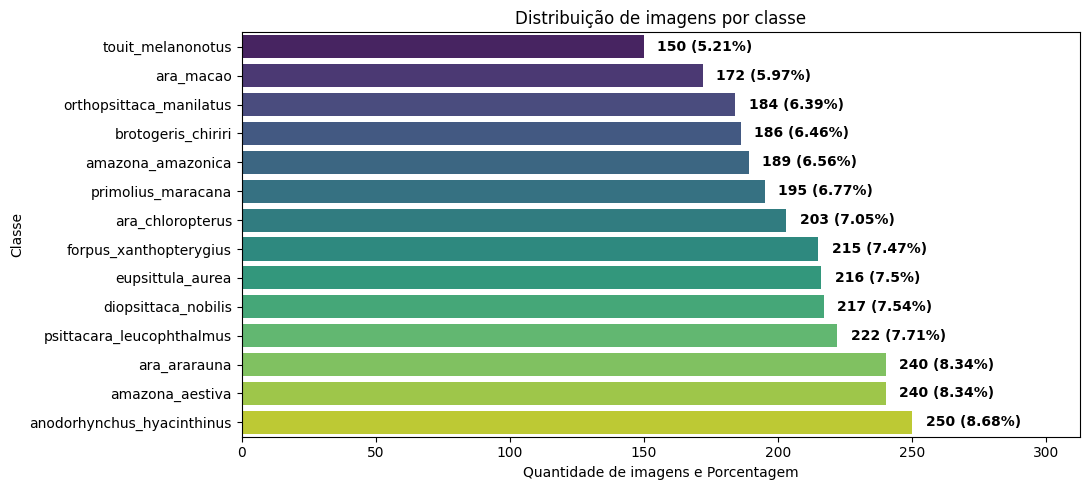

In [ ]:
df = pd.DataFrame([
    (c, sum(1 for _,_,fs in os.walk(os.path.join(dataset_path, c))
            for f in fs if os.path.splitext(f)[1].lower() in exts))
    for c in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, c))
], columns=["classe","imagens"]).sort_values("imagens")

df["pct"] = (df["imagens"] / df["imagens"].sum() * 100).round(2)

plt.figure(figsize=(11,5))
ax = sns.barplot(data=df, x="imagens", y="classe",
                 hue="classe", dodge=False, palette="viridis",
                 orient="h", legend=False)

for i, p in enumerate(ax.patches):
    ax.text(p.get_width()+5, p.get_y()+p.get_height()/2,
            f"{int(p.get_width())} ({df['pct'].iloc[i]}%)",
            va="center", ha="left", weight="bold")

max_val = df["imagens"].max()
ax.set_xlim(0, max_val * 1.25)

ax.set(title="Distribuição de imagens por classe",
       xlabel="Quantidade de imagens e Porcentagem", ylabel="Classe")

plt.tight_layout()
plt.show()


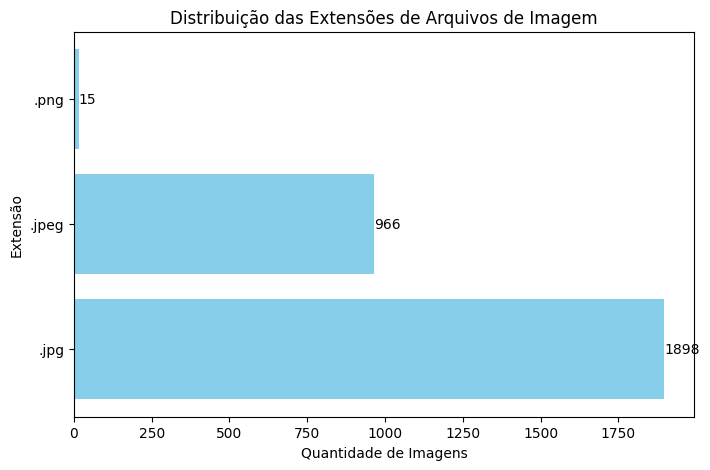

In [ ]:
extensoes = []

# Percorre todas as subpastas e arquivos
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        if ext:  # garante que tem extensão
            extensoes.append(ext)

# Conta as ocorrências de cada extensão
contagem = Counter(extensoes)

# Separa chaves e valores
extensoes_unicas = list(contagem.keys())
quantidades = list(contagem.values())

# Cria gráfico de barras horizontal
plt.figure(figsize=(8,5))
bars = plt.barh(extensoes_unicas, quantidades, color="skyblue")
plt.xlabel("Quantidade de Imagens")
plt.ylabel("Extensão")
plt.title("Distribuição das Extensões de Arquivos de Imagem")

# Adiciona os valores na frente das barras
for bar, qtd in zip(bars, quantidades):
    plt.text(qtd + 0.5, bar.get_y() + bar.get_height()/2,
             str(qtd), va="center")

plt.show()

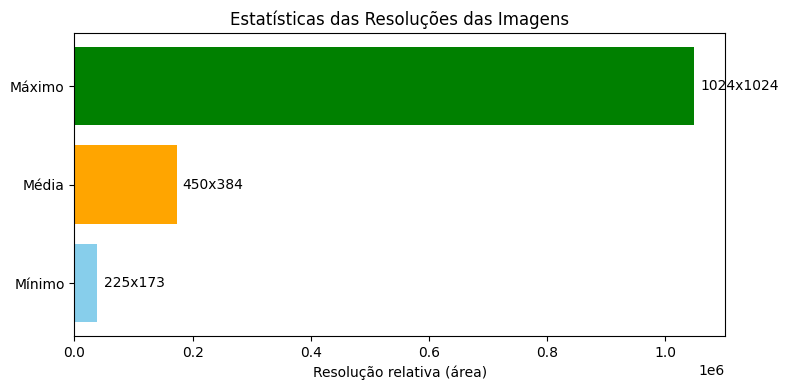

In [ ]:
resolucoes = []

# Percorre todas as subpastas e arquivos
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        if ext in [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif"]:
            try:
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    w, h = img.size
                    resolucoes.append((w, h))
            except:
                pass

# Estatísticas
larguras = [w for w, h in resolucoes]
alturas = [h for w, h in resolucoes]

res_min = (min(larguras), min(alturas))
res_max = (max(larguras), max(alturas))
res_media = (int(np.mean(larguras)), int(np.mean(alturas)))

# Lista de barras com valores e rótulos
barras = [
    ("Mínimo", res_min),
    ("Média", res_media),
    ("Máximo", res_max)
]

# Ordena por largura*altura (área da imagem)
barras.sort(key=lambda x: x[1][0]*x[1][1])

# Extrai dados para plot
nomes = [nome for nome, res in barras]
res_labels = [f"{res[0]}x{res[1]}" for nome, res in barras]
valores = [res[0]*res[1] for nome, res in barras]  # usado só para tamanho da barra

# Cria gráfico horizontal
plt.figure(figsize=(8,4))
bars = plt.barh(range(len(nomes)), valores, color=["skyblue", "orange", "green"])
plt.yticks(range(len(nomes)), nomes)
plt.xlabel("Resolução relativa (área)")
plt.title("Estatísticas das Resoluções das Imagens")

# Adiciona rótulo [LxA] na frente de cada barra
for bar, label in zip(bars, res_labels):
    plt.text(bar.get_width() + max(valores)*0.01,
             bar.get_y() + bar.get_height()/2,
             label, va="center", fontsize=10)

plt.tight_layout()
plt.show()

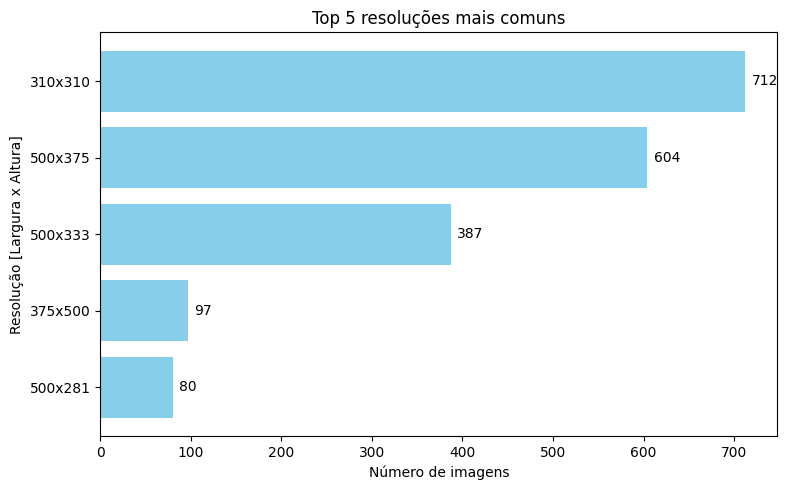

In [ ]:
resolucoes = []

# Percorre todas as subpastas e arquivos
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        if ext in [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif"]:
            try:
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    w, h = img.size
                    resolucoes.append(f"{w}x{h}")  # guarda como string "LxA"
            except:
                pass  # ignora arquivos corrompidos

# Conta quantas imagens têm cada resolução
contagem = Counter(resolucoes)

# Pega as 5 resoluções mais comuns
top5 = contagem.most_common(5)  # retorna lista de tuplas: [(resolucao, quantidade), ...]

# Separa em listas para plot
resolucoes_top5 = [item[0] for item in top5]
quantidades_top5 = [item[1] for item in top5]

# Cria gráfico horizontal
plt.figure(figsize=(8,5))
# inverte listas para colocar a maior barra em cima
bars = plt.barh(resolucoes_top5[::-1], quantidades_top5[::-1], color="skyblue")
plt.xlabel("Número de imagens")
plt.ylabel("Resolução [Largura x Altura]")
plt.title("Top 5 resoluções mais comuns")

# Adiciona número de imagens na frente de cada barra
for bar, qtd in zip(bars, quantidades_top5[::-1]):
    plt.text(qtd + max(quantidades_top5)*0.01,
             bar.get_y() + bar.get_height()/2,
             str(qtd), va="center", fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:

# Número total de resoluções únicas
total_resolucoes = len(contagem)
print(f"Número total de resoluções únicas: {total_resolucoes}")

Número total de resoluções únicas: 361


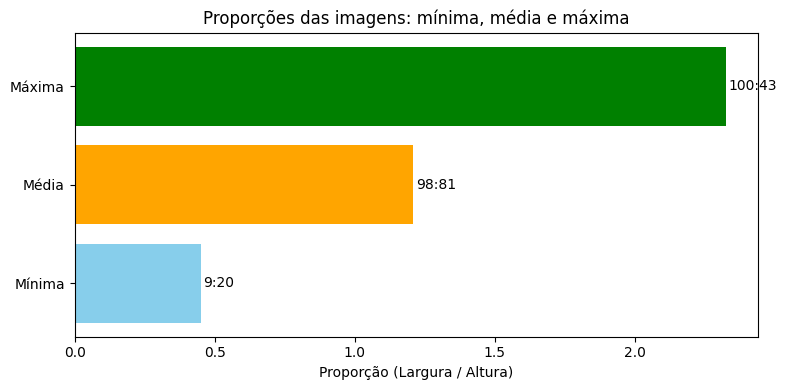

In [ ]:
proporcoes = []

# Percorre todas as subpastas e arquivos
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        if ext in [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif"]:
            try:
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    w, h = img.size
                    proporcao = Fraction(w, h).limit_denominator(100)  # simplifica a fração
                    proporcoes.append(proporcao)
            except:
                pass  # ignora arquivos corrompidos

# Calcula estatísticas
prop_min = min(proporcoes)
prop_max = max(proporcoes)
prop_media_decimal = np.mean([float(p) for p in proporcoes])
prop_media = Fraction(prop_media_decimal).limit_denominator(100)

# Lista para plot
barras = [
    ("Mínima", prop_min),
    ("Média", prop_media),
    ("Máxima", prop_max)
]

# Ordena por proporção decimal
barras.sort(key=lambda x: float(x[1]))

# Extrai dados para plot
nomes = [nome for nome, val in barras]
valores = [float(val) for nome, val in barras]
labels = [f"{val.numerator}:{val.denominator}" for nome, val in barras]  # rótulo L:A

# Cria gráfico horizontal
plt.figure(figsize=(8,4))
bars = plt.barh(nomes, valores, color=["skyblue", "orange", "green"])
plt.xlabel("Proporção (Largura / Altura)")
plt.title("Proporções das imagens: mínima, média e máxima")

# Adiciona rótulo L:A na frente da barra
for bar, label in zip(bars, labels):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             label, va="center", fontsize=10)

plt.tight_layout()
plt.show()

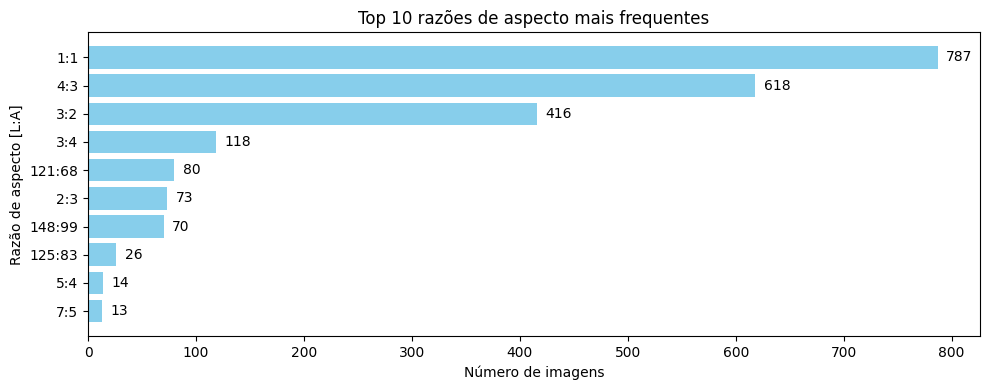

In [ ]:
razoes = []

# Percorre todas as subpastas e arquivos
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        if ext in [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif"]:
            try:
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    w, h = img.size
                    razao = Fraction(w, h).limit_denominator(100)
                    razoes.append(f"{razao.numerator}:{razao.denominator}")
            except:
                pass  # ignora arquivos corrompidos

# Conta quantas imagens têm cada razão
contagem = Counter(razoes)

# Pega as 10 razões mais frequentes
top10 = contagem.most_common(10)  # lista de tuplas: [(razao, quantidade), ...]

# Separa em listas para plot
razoes_top10 = [item[0] for item in top10]
quantidades_top10 = [item[1] for item in top10]

# Cria gráfico horizontal
plt.figure(figsize=(10, max(4, len(razoes_top10)*0.4)))
bars = plt.barh(razoes_top10[::-1], quantidades_top10[::-1], color="skyblue")  # inverte para a mais frequente em cima
plt.xlabel("Número de imagens")
plt.ylabel("Razão de aspecto [L:A]")
plt.title("Top 10 razões de aspecto mais frequentes")

# Adiciona número de imagens na frente de cada barra
for bar, qtd in zip(bars, quantidades_top10[::-1]):
    plt.text(qtd + max(quantidades_top10)*0.01, bar.get_y() + bar.get_height()/2,
             str(qtd), va="center", fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
dataset_final_path = "./datasets/dataset_aumentado"

# Número alvo de imagens por classe
target_count = 300

# Cria pasta final
if not os.path.exists(dataset_final_path):
    os.makedirs(dataset_final_path)

# Funções de data augmentation usando Albumentations
def get_random_augmentation():
    # Escolhe aleatoriamente uma transformação
    aug_type = random.choice(["rotate", "flip", "cutout"])
    if aug_type == "rotate":
        return Compose([Rotate(limit=(10, 340), p=1)])
    elif aug_type == "flip":
        # Aleatoriamente escolhe flip horizontal ou vertical
        if random.random() > 0.5:
            return Compose([HorizontalFlip(p=1)])
        else:
            return Compose([VerticalFlip(p=1)])
    elif aug_type == "cutout":
        return Compose([CoarseDropout(
            max_holes=3, min_holes=1,
            max_height=0.2, min_height=0.1,
            max_width=0.2, min_width=0.1,
            fill_value=0, p=1
        )])

# Percorre todas as classes
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if not os.path.isdir(class_path):
        continue

    # Cria a pasta da classe no dataset final
    final_class_path = os.path.join(dataset_final_path, class_folder)
    os.makedirs(final_class_path, exist_ok=True)

    # Lista todas as imagens
    images = [f for f in os.listdir(class_path) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

    # Copia imagens originais para a pasta final
    for img_name in images:
        shutil.copy(os.path.join(class_path, img_name), os.path.join(final_class_path, img_name))

    current_count = len(images)
    print(f"Classe '{class_folder}' tem {current_count} imagens. Processando...")

    # Gera imagens até atingir target_count
    while current_count < target_count:
        img_name = random.choice(images)
        img_path = os.path.join(class_path, img_name)

        # Carrega imagem com OpenCV
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Aplica uma transformação aleatória
        aug = get_random_augmentation()
        augmented = aug(image=img)['image']

        # Salva imagem final
        save_name = f"aug_{current_count}.jpg"
        save_path = os.path.join(final_class_path, save_name)
        augmented_bgr = cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR)
        cv2.imwrite(save_path, augmented_bgr)

        current_count += 1

    print(f"Classe '{class_folder}' finalizada com {current_count} imagens.")

print("Data augmentation concluído. Dataset final criado em 'dataset_final'.")

Classe 'forpus_xanthopterygius' tem 215 imagens. Processando...


/tmp/ipython-input-4006540478.py:23: UserWarning: Argument(s) 'max_holes, min_holes, max_height, min_height, max_width, min_width, fill_value' are not valid for transform CoarseDropout
  return Compose([CoarseDropout(


Classe 'forpus_xanthopterygius' finalizada com 300 imagens.
Classe 'anodorhynchus_hyacinthinus' tem 250 imagens. Processando...
Classe 'anodorhynchus_hyacinthinus' finalizada com 300 imagens.
Classe 'touit_melanonotus' tem 150 imagens. Processando...
Classe 'touit_melanonotus' finalizada com 300 imagens.
Classe 'amazona_amazonica' tem 189 imagens. Processando...
Classe 'amazona_amazonica' finalizada com 300 imagens.
Classe 'eupsittula_aurea' tem 216 imagens. Processando...
Classe 'eupsittula_aurea' finalizada com 300 imagens.
Classe 'ara_ararauna' tem 240 imagens. Processando...
Classe 'ara_ararauna' finalizada com 300 imagens.
Classe 'ara_chloropterus' tem 203 imagens. Processando...
Classe 'ara_chloropterus' finalizada com 300 imagens.
Classe 'ara_macao' tem 172 imagens. Processando...
Classe 'ara_macao' finalizada com 300 imagens.
Classe 'amazona_aestiva' tem 240 imagens. Processando...
Classe 'amazona_aestiva' finalizada com 300 imagens.
Classe 'orthopsittaca_manilatus' tem 184 ima

In [ ]:
"""!zip -r meus_arquivos.zip /content/datasets/dataset_final
from google.colab import files
files.download("meus_arquivos.zip")"""

  adding: content/datasets/dataset_final/ (stored 0%)
  adding: content/datasets/dataset_final/forpus_xanthopterygius/ (stored 0%)
  adding: content/datasets/dataset_final/forpus_xanthopterygius/forpus_xanthopterygius_118.jpg (deflated 0%)
  adding: content/datasets/dataset_final/forpus_xanthopterygius/forpus_xanthopterygius_113.jpeg (deflated 0%)
  adding: content/datasets/dataset_final/forpus_xanthopterygius/forpus_xanthopterygius_3.jpg (deflated 0%)
  adding: content/datasets/dataset_final/forpus_xanthopterygius/forpus_xanthopterygius_205.jpg (deflated 0%)
  adding: content/datasets/dataset_final/forpus_xanthopterygius/forpus_xanthopterygius_131.jpeg (deflated 0%)
  adding: content/datasets/dataset_final/forpus_xanthopterygius/forpus_xanthopterygius_212.jpg (deflated 0%)
  adding: content/datasets/dataset_final/forpus_xanthopterygius/forpus_xanthopterygius_168.jpeg (deflated 0%)
  adding: content/datasets/dataset_final/forpus_xanthopterygius/aug_270.jpg (deflated 2%)
  adding: conte

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 7. Trenamento

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
from keras.models import Sequential
from keras import datasets, layers, models
from keras.utils import to_categorical
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns


In [ ]:
data_dir = "./datasets/dataset_aumentado"

# Pastas de saída
train_dir = "./datasets/train_images"
test_dir = "./datasets/test_images"

# Criar as pastas de destino
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Definir proporções
train_split = 0.8
test_split = 0.2

# Loop em cada subpasta (classe)
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Criar subpastas correspondentes em train/test
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Listar imagens da classe
    images = os.listdir(class_path)
    random.shuffle(images)

    # Separar em 80% / 20%
    split_idx = int(len(images) * train_split)
    train_files = images[:split_idx]
    test_files = images[split_idx:]

    # Copiar arquivos
    for img in train_files:
        shutil.copy(os.path.join(class_path, img),
                    os.path.join(train_dir, class_name, img))
    for img in test_files:
        shutil.copy(os.path.join(class_path, img),
                    os.path.join(test_dir, class_name, img))

print("✅ Divisão concluída!")

✅ Divisão concluída!


In [ ]:
"""!zip -r testImage.zip /content/datasets/test_images
from google.colab import files
files.download("testImage.zip")

!zip -r trainImage.zip /content/datasets/train_images
from google.colab import files
files.download("trainImage.zip")"""

  adding: content/datasets/test_images/ (stored 0%)
  adding: content/datasets/test_images/forpus_xanthopterygius/ (stored 0%)
  adding: content/datasets/test_images/forpus_xanthopterygius/forpus_xanthopterygius_205.jpg (deflated 0%)
  adding: content/datasets/test_images/forpus_xanthopterygius/forpus_xanthopterygius_140.jpg (deflated 0%)
  adding: content/datasets/test_images/forpus_xanthopterygius/forpus_xanthopterygius_193.jpeg (deflated 0%)
  adding: content/datasets/test_images/forpus_xanthopterygius/aug_244.jpg (deflated 0%)
  adding: content/datasets/test_images/forpus_xanthopterygius/forpus_xanthopterygius_53.jpeg (deflated 1%)
  adding: content/datasets/test_images/forpus_xanthopterygius/forpus_xanthopterygius_215.jpeg (deflated 0%)
  adding: content/datasets/test_images/forpus_xanthopterygius/aug_256.jpg (deflated 2%)
  adding: content/datasets/test_images/forpus_xanthopterygius/forpus_xanthopterygius_158.jpg (deflated 0%)
  adding: content/datasets/test_images/forpus_xanthop

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/datasets/train_images/ (stored 0%)
  adding: content/datasets/train_images/forpus_xanthopterygius/ (stored 0%)
  adding: content/datasets/train_images/forpus_xanthopterygius/forpus_xanthopterygius_118.jpg (deflated 0%)
  adding: content/datasets/train_images/forpus_xanthopterygius/forpus_xanthopterygius_113.jpeg (deflated 0%)
  adding: content/datasets/train_images/forpus_xanthopterygius/forpus_xanthopterygius_3.jpg (deflated 0%)
  adding: content/datasets/train_images/forpus_xanthopterygius/forpus_xanthopterygius_131.jpeg (deflated 0%)
  adding: content/datasets/train_images/forpus_xanthopterygius/forpus_xanthopterygius_212.jpg (deflated 0%)
  adding: content/datasets/train_images/forpus_xanthopterygius/forpus_xanthopterygius_168.jpeg (deflated 0%)
  adding: content/datasets/train_images/forpus_xanthopterygius/aug_270.jpg (deflated 2%)
  adding: content/datasets/train_images/forpus_xanthopterygius/forpus_xanthopterygius_56.jpeg (deflated 0%)
  adding: content/dataset

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np
import os
import matplotlib.pyplot as plt

# 1. Definição dos parâmetros e caminhos
# ---
# A lista de nomes de classes que define a ordem dos rótulos
class_names = [
    "amazona_aestiva",
    "amazona_amazonica",
    "anodorhynchus_hyacinthinus",
    "ara_ararauna",
    "ara_chloropterus",
    "ara_macao",
    "brotogeris_chiriri",
    "diopsittaca_nobilis",
    "eupsittula_aurea",
    "forpus_xanthopterygius",
    "orthopsittaca_manilatus",
    "primolius_maracana",
    "psittacara_leucophthalmus",
    "touit_melanonotus",
]

# Defina o caminho base e os caminhos para os dados de treino e teste.
# **ATENÇÃO:** Você deve mudar estes caminhos para os caminhos reais em seu sistema.
BASE_PATH = './datasets'  # Assumindo que 'test_images' e 'train_images' estão no diretório atual
train_dir = os.path.join(BASE_PATH, 'train_images')
test_dir = os.path.join(BASE_PATH, 'test_images')

# Parâmetros para carregamento das imagens
IMAGE_SIZE = (128, 128) # Tamanho da imagem que será redimensionada
BATCH_SIZE = 32         # Número de imagens por batch durante o carregamento

# 2. Carregamento e Pré-processamento dos dados
# ---

print("Carregando dados de TREINO...")
# dataset de TREINO
train_ds = image_dataset_from_directory(
    train_dir,
    labels='inferred',                   # Rótulos inferidos pelo nome das subpastas
    label_mode='int',                    # Rótulos codificados como inteiros (0, 1, 2, ...)
    class_names=class_names,             # Garante a ordem correta das classes
    image_size=IMAGE_SIZE,               # Redimensiona todas as imagens
    interpolation='bilinear',
    shuffle=True,                        # Embaralha os dados de treino
    batch_size=BATCH_SIZE
)

print("\nCarregando dados de TESTE...")
# dataset de TESTE
test_ds = image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    image_size=IMAGE_SIZE,
    interpolation='bilinear',
    shuffle=False,                       # Não é necessário embaralhar dados de teste
    batch_size=BATCH_SIZE
)

# Pré-processamento: normalização dos valores de pixel para o intervalo [0, 1]
# A maioria dos modelos de aprendizado profundo espera esta normalização.
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


# 3. Conversão para Arrays NumPy (Vetores)
# ---

def dataset_to_numpy(dataset):
    """Converte um dataset de tf.data.Dataset em dois arrays NumPy (imagens e labels)."""
    images = []
    labels = []
    for img_batch, label_batch in dataset.unbatch().as_numpy_iterator():
        images.append(img_batch)
        labels.append(label_batch)

    # Empilha as listas para formar um único array NumPy
    if not images:
        print("Atenção: Nenhum dado encontrado no dataset.")
        return np.array([]), np.array([])

    return np.array(images), np.array(labels)

print("\nConvertendo datasets de treino para arrays NumPy...")
train_images, train_labels = dataset_to_numpy(train_ds)

print("Convertendo datasets de teste para arrays NumPy...")
test_images, test_labels = dataset_to_numpy(test_ds)


# 4. Exibição dos resultados e resumo
# ---
print("\n" + "="*50)
print("RESUMO DOS VETORES GERADOS")
print("="*50)
print(f"train_images (imagens de treino): {train_images.shape}")
print(f"train_labels (rótulos de treino): {train_labels.shape}")
print(f"test_images (imagens de teste): {test_images.shape}")
print(f"test_labels (rótulos de teste): {test_labels.shape}")
print(f"Tipo de dado das imagens: {train_images.dtype}")
print(f"Tipo de dado dos rótulos: {train_labels.dtype}")

# Verificação de um rótulo
if train_labels.size > 0:
    exemplo_label_idx = train_labels[0]
    nome_classe = class_names[exemplo_label_idx]
    print(f"\nExemplo: O primeiro rótulo ({exemplo_label_idx}) corresponde à classe: '{nome_classe}'")

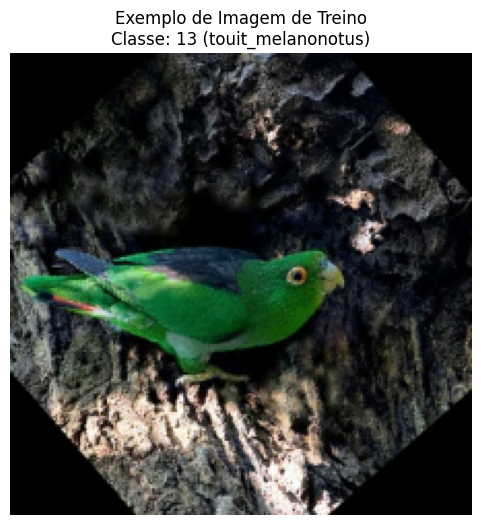

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Certifique-se de que 'class_names', 'train_images' e 'train_labels'
# foram definidos na célula anterior.

if train_images.size > 0:
    # 1. Seleciona a primeira imagem e seu rótulo
    primeira_imagem = train_images[3]
    primeiro_label_index = train_labels[3]

    # 2. Obtém o nome da classe
    nome_da_classe = class_names[primeiro_label_index]

    # 3. Plota a imagem
    plt.figure(figsize=(6, 6))

    # A imagem já está normalizada (entre 0 e 1), então ela pode ser exibida diretamente.
    plt.imshow(primeira_imagem)

    plt.title(f"Exemplo de Imagem de Treino\nClasse: {primeiro_label_index} ({nome_da_classe})")
    plt.axis('off') # Remove os eixos
    plt.show()

else:
    print("Os arrays de treino estão vazios. Verifique os caminhos dos diretórios na célula de carregamento.")

In [ ]:
import tensorflow as tf

# Lista todos os dispositivos disponíveis (CPU e GPU)
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Configuração para que o TensorFlow aloque memória de forma dinâmica
        # Isso ajuda a evitar o erro "CUDNN_STATUS_ALLOC_FAILED"
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # Define que o TensorFlow usará o primeiro dispositivo GPU encontrado
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        print("---")
        print("GPU CONFIGURADA COM SUCESSO!")
        print(f"Dispositivo GPU encontrado: {gpus[0].name}")
        print("---")

    except RuntimeError as e:
        # Erro de tempo de execução se a configuração for definida após a inicialização da GPU
        print(f"Erro ao configurar a GPU: {e}")

else:
    print("---")
    print("Nenhuma GPU (CUDA) detectada. O TensorFlow usará a CPU.")
    print("Verifique se os drivers NVIDIA, CUDA Toolkit e cuDNN estão instalados corretamente.")
    print("---")

# Exibe o dispositivo padrão onde as operações serão executadas
print(f"\nDispositivo padrão para execução: {tf.config.list_logical_devices()}")

---
Nenhuma GPU (CUDA) detectada. O TensorFlow usará a CPU.
Verifique se os drivers NVIDIA, CUDA Toolkit e cuDNN estão instalados corretamente.
---

Dispositivo padrão para execução: [LogicalDevice(name='/device:CPU:0', device_type='CPU')]


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
import numpy as np

# --- As variáveis train_images, train_labels, test_images, test_labels e class_names
# --- DEVEM ter sido carregadas e convertidas em arrays NumPy na primeira célula de código.

# 1. Definição das Classes e Normalização
# -------------------------------------

# Redefinindo class_names com a capitalização que você usou (embora o índice seja o que importa)
class_names = ['Amazona aestiva', 'Amazona amazonica', 'Anodorhynchus hyacinthinus', 'Ara ararauna',
               'Ara chloropterus', 'Ara macao', 'Brotogeris chiriri', 'Diopsittaca nobilis',
               'Eupsittula aurea', 'Forpus xanthopterygius', 'Orthopsittaca manilatus',
               'Primolius maracana', 'Psittacara leucophthalmus', 'Touit melanonotus']

num_classes = len(class_names) # Garante que o número de classes é 14

# Atenção: As imagens JÁ ESTAVAM NORMALIZADAS (divididas por 255.0) na célula anterior.
# Não é necessário normalizar novamente, mas manteremos o código aqui para clareza
# caso você tenha pulado a normalização na célula anterior.

# Normalizando as imagens (Se necessário. Caso contrário, esta linha não faz nada.)
# train_images = train_images / 255.0  # Comentei para evitar normalização dupla
# test_images = test_images / 255.0   # Comentei para evitar normalização dupla

# 2. Codificação One-Hot dos Rótulos (CORREÇÃO CRÍTICA)
# ----------------------------------------------------
# A função `to_categorical` deve receber o VETOR DE RÓTULOS (inteiros: [0, 1, 2, ...]),
# e NÃO a lista de nomes de classes (strings).

# Usando os vetores de rótulos (inteiros) gerados na primeira célula:
if train_labels.dtype != np.int64 and train_labels.dtype != np.int32:
     print("Atenção: Os rótulos de treino parecem já ter sido codificados ou não são inteiros.")

train_labels_one_hot = to_categorical(train_labels, num_classes)
test_labels_one_hot = to_categorical(test_labels, num_classes)

print(f"Shape dos rótulos de treino após One-Hot Encoding: {train_labels_one_hot.shape}")
print(f"Shape dos rótulos de teste após One-Hot Encoding: {test_labels_one_hot.shape}")

# 3. Definição do Modelo (CORREÇÕES no INPUT_SHAPE e Camada Final)
# -----------------------------------------------------------

# O INPUT_SHAPE deve ser o shape das imagens carregadas.
# Na primeira célula, usamos IMAGE_SIZE = (224, 224).
if train_images.shape:
    INPUT_SHAPE = train_images.shape[1:]  # Ex: (224, 224, 3)
else:
    # Caso o shape não seja detectado, use o valor da primeira célula
    INPUT_SHAPE = (224, 224, 3)

KERNEL_SIZE = (3, 3)

model = models.Sequential([
    # Bloco 1
    layers.Conv2D(filters=16, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same', name='conv1_1'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=16, kernel_size=KERNEL_SIZE, activation='relu', padding='same', name='conv1_2'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Bloco 2
    layers.Conv2D(filters=32, kernel_size=KERNEL_SIZE, activation='relu', padding='same', name='conv2_1'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=32, kernel_size=KERNEL_SIZE, activation='relu', padding='same', name='conv2_2'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Bloco 3
    layers.Conv2D(filters=64, kernel_size=KERNEL_SIZE, activation='relu', padding='same', name='conv3_1'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=KERNEL_SIZE, activation='relu', padding='same', name='conv3_2'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Classificador
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    # CORREÇÃO: A camada de saída deve ter o número correto de classes (14, não 10)
    layers.Dense(num_classes, activation='softmax')
])

# 4. Compilação e Treinamento
# ---------------------------

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\nResumo do Modelo:")
model.summary()

# Treinamento do modelo
print("\nIniciando Treinamento...")
history = model.fit(
    train_images,
    train_labels_one_hot, # Usamos o vetor de rótulos codificados em One-Hot
    batch_size=64,
    epochs=25,
    validation_data=(test_images, test_labels_one_hot) # Usamos o vetor de rótulos codificados em One-Hot
)

Shape dos rótulos de treino após One-Hot Encoding: (3360, 14)
Shape dos rótulos de teste após One-Hot Encoding: (840, 14)

Resumo do Modelo:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 224, 224, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,497,950 (24.79 MB)

 Trainable params: 6,497,246 (24.79 MB)

 Non-trainable params: 704 (2.75 KB)


Iniciando Treinamento...
Epoch 1/25
16/53 ━━━━━━━━━━━━━━━━━━━━ 9:18 15s/step - accuracy: 0.1026 - loss: 3.2522

In [ ]:
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Perda do treino', 'Perda da validação'], fontsize=14)
plt.xlabel('Épocas', fontsize=10)
plt.ylabel('Perda', fontsize=10)
plt.title('Curvas de perda', fontsize=12)

# Curva de acurácia
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Acurácia do treino', 'Acurácia da validação'], fontsize=14)
plt.xlabel('Épocas', fontsize=10)
plt.ylabel('Acurácia', fontsize=10)
plt.title('Curva de acurácia', fontsize=12)

# Mostrando o verdadeiro vs. Resultado previsto

# Gera a matriz de confusão

# Calcular e exibir a matriz de confusão
cm_cifar = confusion_matrix(np.argmax(test_labels, axis=1), pred_classes)
disp_cifar = ConfusionMatrixDisplay(confusion_matrix=cm_cifar, display_labels=class_names)

# Usamos um tamanho de figura maior e rotação nos rótulos para melhor visualização
fig, ax = plt.subplots(figsize=(10, 10))
disp_cifar.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - CIFAR-10")
plt.xticks(rotation=45)
plt.show()

# 8. Resultados

In [ ]:
! apt install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (84.9 kB/s)
Selecting previously unselected package tree.
(Reading database ... 126675 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


# 9. Conclusão

# 10. Referências

TANG, Jiayi. Comparative analysis of CNN architectures for bird species classification. ITM Web of Conferences, [S. l.], v. 78, p. 02019, 2025. DOI: 10.1051/itmconf/20257802019.